In [1]:
# Imports
import os, sys
import pandas as pd
import numpy as np
import gzip
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# Sklearn libraries.
from sklearn import datasets, linear_model, ensemble, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
import string

from collections import Counter


### 1. Load Data

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
# Unzip gz file.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

# Load JSON into dataframe.
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


In [4]:
start = time.time()
df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
end = time.time()
print "Time Used %fs" %(end - start)

Time Used 41.126850s


### 2. Data Exploration

In [73]:
print df.columns

print df['reviewText'][0]

df.head(5)

Index([u'reviewerID', u'asin', u'reviewerName', u'helpful', u'unixReviewTime',
       u'reviewText', u'overall', u'reviewTime', u'summary'],
      dtype='object')
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",1297468800,This is a great tutu and at a really great pri...,5.0,"02 12, 2011",Great tutu- not cheaply made
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",1358553600,I bought this for my 4 yr old daughter for dan...,5.0,"01 19, 2013",Very Cute!!
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",1357257600,What can I say... my daughters have it in oran...,5.0,"01 4, 2013",I have buy more than one
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]",1398556800,"We bought several tutus at once, and they are ...",5.0,"04 27, 2014","Adorable, Sturdy"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",1394841600,Thank you Halo Heaven great product for Little...,5.0,"03 15, 2014",Grammy's Angels Love it


In [10]:
len(df)

278677

#### Exploring helpfulness scores.

In [6]:
helpfulness = []
total_votes = []
for i in df['helpful']:
    if i[1] == 0:
        helpfulness.append(np.nan)
        total_votes.append(np.nan)
    else:
        helpfulness.append(float(i[0])/i[1])
        total_votes.append(i[1])
        
# Convert to numpy array.
helpfulness = np.array(helpfulness)
total_votes = np.array(total_votes)

In [35]:
sum(np.isnan(helpfulness[0:100]))
print df['helpful'][0:30]

0     [0, 0]
1     [0, 0]
2     [0, 0]
3     [0, 0]
4     [0, 0]
5     [0, 0]
6     [0, 0]
7     [0, 0]
8     [0, 0]
9     [7, 8]
10    [0, 0]
11    [0, 0]
12    [0, 0]
13    [1, 1]
14    [0, 0]
15    [0, 0]
16    [0, 0]
17    [0, 0]
18    [0, 0]
19    [0, 0]
20    [0, 0]
21    [0, 0]
22    [1, 2]
23    [1, 1]
24    [0, 1]
25    [1, 2]
26    [0, 0]
27    [0, 0]
28    [0, 0]
29    [0, 0]
Name: helpful, dtype: object


In [7]:
print "average helpfulness %f" %np.nanmean(helpfulness)
print "number of reviews with helpfulness score: %i" %np.count_nonzero(~np.isnan(helpfulness))
print "total reviews: ", len(df)
print "percent of reviews with helpfulness score: ", (np.count_nonzero(~np.isnan(helpfulness)) / float(len(df)))

average helpfulness 0.780014
number of reviews with helpfulness score: 87021
total reviews:  278677
percent of reviews with helpfulness score:  0.312264736595


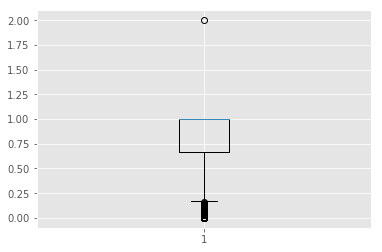

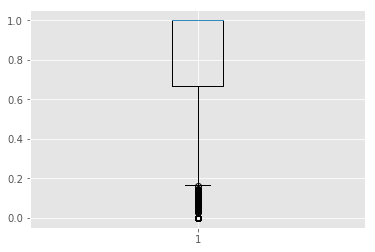

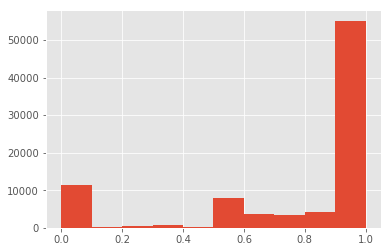

In [8]:
# Plot boxplot.
nonnan_helpfulness = helpfulness[~np.isnan(helpfulness)]

plt.figure()
plt.boxplot(nonnan_helpfulness)

# Remove invalid record.
helpfulness_clean = nonnan_helpfulness[np.where(nonnan_helpfulness < 2)]

plt.figure()
plt.boxplot(helpfulness_clean[~np.isnan(helpfulness_clean)])

# Plot histogram
plt.figure()
plt.hist(helpfulness_clean)

plt.show()

In [9]:
for i, row in df.iterrows():
    helpful = row['helpful']
    if helpful[0] > helpful[1]:
        print row

reviewerID                                           A353U0L2HAMSHV
asin                                                     B000JD2614
reviewerName                   Cricket "Living life and loving it!"
helpful                                                      [4, 2]
unixReviewTime                                           1234828800
reviewText        I have been waiting for these to go on sale fo...
overall                                                           5
reviewTime                                              02 17, 2009
summary                                              A gift for me!
Name: 30730, dtype: object


#### Exploring distribution of helpfulness votes.

In [10]:
print "average # votes for reviews with votes: %f" %np.nanmean(total_votes)
print "min # votes for reviews with votes: %i" %np.nanmin(total_votes)
print "max # votes for reviews with votes: %i" %np.nanmax(total_votes)

average # votes for reviews with votes: 4.305961
min # votes for reviews with votes: 1
max # votes for reviews with votes: 1267


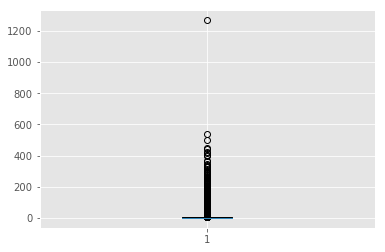

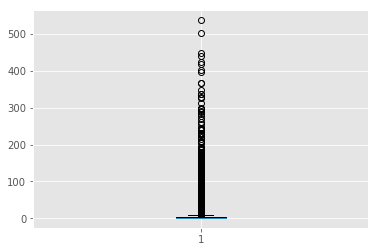

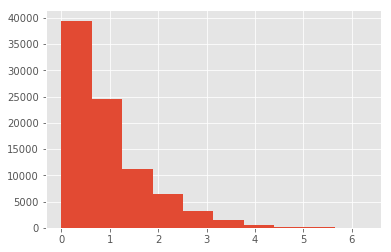

In [11]:
# Create array that contains total votes per review with >0 votes.
non_zero_total_votes = total_votes[np.isfinite(total_votes)]

# Plot boxplot.
plt.figure()
plt.boxplot(non_zero_total_votes)

# Remove outlier.
non_zero_total_votes_minus_outliers = non_zero_total_votes[np.where(non_zero_total_votes < 1267)]

# Plot boxplot.
plt.figure()
plt.boxplot(non_zero_total_votes_minus_outliers)

# Plot histogram using log(total votes) due to right skewed distribution.
plt.figure()
plt.hist(np.log(non_zero_total_votes_minus_outliers))

plt.show()

#### Exploring review text lengths.

In [12]:
# Compute review lengths.
review_lengths = np.array([len(x) for x in df['reviewText']])
print review_lengths
print "average review length: %i" %np.mean(review_lengths)
print "min review length: %i" %np.min(review_lengths)
print "max review length: %i" %np.max(review_lengths)

[ 172  306  312 ...,  914 1126 1295]
average review length: 315
min review length: 0
max review length: 22646


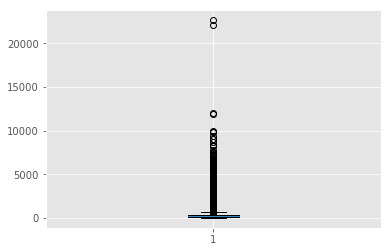

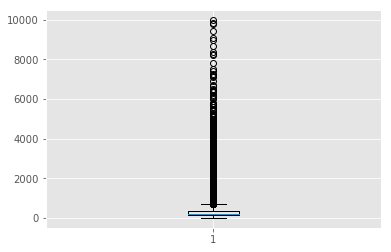

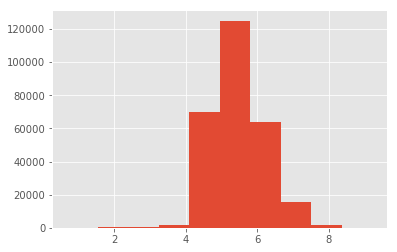

In [9]:
# Plot boxplot.
plt.figure()
plt.boxplot(review_lengths)

# Remove outliers.
review_lengths_minus_outliers = review_lengths[np.where(np.logical_and(review_lengths > 0, review_lengths < 10000))]

# Plot boxplot.
plt.figure()
plt.boxplot(review_lengths_minus_outliers)

# # Plot histogram using log(review length) due to right skewed distribution.
plt.figure()
plt.hist(np.log(review_lengths_minus_outliers))

plt.show()

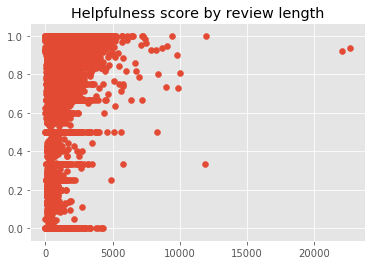

In [13]:
# Remove invalid and nan values.
helpfulness_clean = np.delete(helpfulness, 30730)
review_lengths_clean = np.delete(review_lengths, 30730)
nonnan_helpfulness_clean = helpfulness_clean[~np.isnan(helpfulness_clean)]
nonnan_review_lengths_clean = review_lengths_clean[~np.isnan(helpfulness_clean)]

# Print scatterplot of review length to helpfulness score.
plt.figure()
plt.scatter(nonnan_review_lengths_clean, nonnan_helpfulness_clean)
plt.title("Helpfulness score by review length")
plt.show()

In [147]:
# Compute correlation.
np.corrcoef(nonnan_review_lengths_clean, nonnan_helpfulness_clean)[1,0]

0.054565284474689578

#### Exploring review scores.

In [16]:
# Compute scores.
review_scores = np.array(df['overall'])
print "average review score: %i" %np.mean(review_scores)
print "min review score: %i" %np.min(review_scores)
print "max review score: %i" %np.max(review_scores)

average review score: 4
min review score: 1
max review score: 5


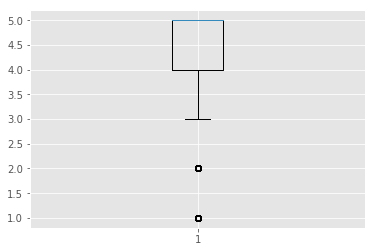

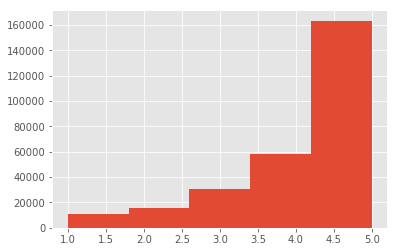

In [17]:
# Plot boxplot.
plt.figure()
plt.boxplot(review_scores)

# # Plot histogram.
plt.figure()
plt.hist(review_scores, bins=5)

plt.show()

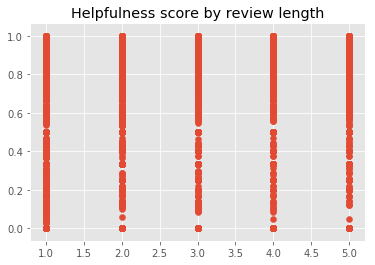

In [18]:
# Remove invalid and nan values.
review_scores_clean = np.delete(review_scores, 30730)
nonnan_review_scores_clean = review_scores_clean[~np.isnan(helpfulness_clean)]

# Print scatterplot of review length to helpfulness score.
plt.figure()
plt.scatter(nonnan_review_scores_clean, nonnan_helpfulness_clean)
plt.title("Helpfulness score by review length")
plt.show()

In [158]:
# Compute correlation.
np.corrcoef(nonnan_review_scores_clean, nonnan_helpfulness_clean)[1,0]

0.18085804717359091

### 3. Build Baseline Model

In [19]:
nltk.download('all')

[nltk_data] Downloading collection u'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/annie_y_lee/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/annie_y_lee/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/annie_y_lee/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/annie_y_lee/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/annie_y_lee/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/annie_y_lee/nltk_data...
[nltk_data]    |   Package cess_cat is alre

True

In [20]:
#extract the review text
doc = np.array(df['reviewText'])

# Filter down to reviews with helpfulness scores.
# Remove item with invalid helpfulness score.
doc_clean = np.delete(doc, 30730)
nonnan_doc_clean = doc_clean[~np.isnan(helpfulness_clean)]

In [13]:
def get_tokens(docs):
    tokens =[]
    for i in docs:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        tokens.extend(token)
    return tokens

In [14]:
##only use the first 10000 doc, since it is too large
# token = get_tokens(doc[0:10000])
tokens = get_tokens(nonnan_doc_clean)

In [28]:
print len(tokens)
# from collections import Counter
# filtered = [w for w in tokens if not w in stopwords.words('english')]
# count = Counter(filtered)
# print count.most_common(10)

6886128


In [ ]:
len(count)

#### Feature Extraction 1: TF-IDF

In [19]:
##tf-idf transformation
##based on this page: http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
token_dict = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

for i, text in enumerate(nonnan_doc_clean):
    
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    token_dict[i] = no_punctuation
        
#this can take some time
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(token_dict.values())

In [30]:
print "Shape of token_dict: ", len(token_dict)
print "Shape of tfs: ", tfs.shape
print tfs[0,:] #sparse matrix
print token_dict[0]
print "Items in vocab: ", len(tfidf.vocabulary_)
print "ID of tutu: ", tfidf.vocabulary_['tutu']

 Shape of token_dict:  87020
Shape of tfs:  (87020, 107593)
  (0, 68058)	0.216703480324
  (0, 98123)	0.212744944401
  (0, 98629)	0.176596053643
  (0, 66494)	0.0631953401241
  (0, 70642)	0.109490227093
  (0, 98082)	0.241394045464
  (0, 101088)	0.131950970803
  (0, 15931)	0.0850771708476
  (0, 98121)	0.373710794984
  (0, 73129)	0.160965850583
  (0, 90129)	0.0820228732145
  (0, 22822)	0.131138445196
  (0, 22750)	0.086428440649
  (0, 58546)	0.227069494933
  (0, 64800)	0.127663141811
  (0, 56932)	0.0556624302158
  (0, 21636)	0.110400926372
  (0, 7941)	0.10163576141
  (0, 20105)	0.13069505841
  (0, 38518)	0.0732511497488
  (0, 73979)	0.160139102017
  (0, 81117)	0.143789692481
  (0, 77309)	0.185429593707
  (0, 71542)	0.109490227093
  (0, 39073)	0.117652333702
  (0, 43511)	0.241394045464
  (0, 2618)	0.158957868637
  (0, 106826)	0.241394045464
  (0, 29536)	0.0983717387243
  (0, 103288)	0.101268725295
  (0, 84275)	0.0970537583343
  (0, 6929)	0.18613020175
  (0, 84834)	0.108786125523
  (0, 39452)

In [75]:
#!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /Users/legu/anaconda/lib/python2.7/site-packages


In [22]:
# helpfulness[0:10000].reshape(10000,1)
y = np.reshape(nonnan_helpfulness_clean,(-1,1))
print y.shape

(87020, 1)


In [23]:
# Normalizes y be [0,1]
y_norm = np.rint(y)

In [168]:
# No longer needed since we removed nans earlier on.
# nan_ind = (np.isnan(helpfulness[0:10000]))
# tfs_remove_nan = tfs[~nan_ind]
# y_remove_nan = y[~nan_ind]

#### Preparing train/test sets

In [35]:
#random split
msk = np.random.rand(tfs.shape[0]) <= 0.7

X_train = tfs[msk]
X_test = tfs[~msk]
y_train = y[msk]
y_test = y[~msk]

In [79]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(61008, 107593)
(26012, 107593)
(61008, 1)
(26012, 1)


#### Linear Model

In [214]:
#build linear model
# import matplotlib.pyplot as plt
# load the iris datasets

# fit a linear regression model to the data
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)
print(regr)
# make predictions
# expected = dataset.target
predicted = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((predicted - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
('Coefficients: \n', array([[-0.70224571, -0.26878266, -0.21638084, ...,  0.        ,
        -1.95550203,  1.42154242]]))
Mean squared error: 0.37
Variance score: -2.10


In [217]:
print predicted.shape
print y_test.shape

(26182, 1)
(26182, 1)


#### Normalizing helpfulness scores

In [78]:
# Round helpfulness scores to [0,1] labels.
y_train_norm = np.rint(y_train)
y_test_norm = np.rint(y_test)

#### Logistic Regression

In [212]:
regr2 = linear_model.LogisticRegression()

# Train the model using the training sets
regr2.fit(X_train, y_train_norm)
print(regr2)
# make predictions
predicted2 = regr2.predict(X_test)

# The coefficients
print('Coefficients: \n', regr2.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((predicted2 - y_test_norm) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr2.score(X_test, y_test_norm))
print(metrics.classification_report(y_test_norm, predicted2))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
('Coefficients: \n', array([[-0.20440635,  0.07116786, -0.54615414, ...,  0.        ,
        -0.14703691,  0.09026733]]))
Mean squared error: 0.24
Variance score: 0.77
             precision    recall  f1-score   support

        0.0       0.50      0.04      0.07      5968
        1.0       0.78      0.99      0.87     20214

avg / total       0.71      0.77      0.69     26182



#### Random Forest

In [234]:
rf = ensemble.RandomForestClassifier(n_estimators = 100)

# Train the model using the training sets
rf.fit(X_train, y_train_norm)
print(rf)
# make predictions
predicted_rf = rf.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((predicted_rf - y_test_norm) ** 2))
# Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % regr2.score(X_test, y_test_norm))

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Mean squared error: 0.23


In [239]:
print(metrics.classification_report(y_test_norm, predicted_rf))

             precision    recall  f1-score   support

        0.0       0.68      0.01      0.03      5968
        1.0       0.77      1.00      0.87     20214

avg / total       0.75      0.77      0.68     26182



#### Feature Extraction 2: CountVectorizer
We expect simple counts to perform worse than TF-IDF. This is also used for baseline comparison.

In [120]:
cv = CountVectorizer(tokenizer=tokenize, stop_words='english', dtype=np.float32, max_features=10000)
cv_features = cv.fit_transform(token_dict.values())

In [121]:
CV_train = cv_features[msk]
CV_test = cv_features[~msk]

In [122]:
print CV_train.shape
print CV_test.shape

(61008, 10000)
(26012, 10000)


In [232]:
cv_regr = linear_model.LogisticRegression()

# Train the model using the training sets
cv_regr.fit(CV_train, y_train_norm)
print(cv_regr)
# make predictions
cv_predicted = cv_regr.predict(CV_test)

# The coefficients
print('Coefficients: \n', cv_regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((cv_predicted - y_test_norm) ** 2))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
('Coefficients: \n', array([[-0.22478245,  0.12051003, -0.57436598, ...,  0.        ,
        -0.15019969,  0.24599894]]))
Mean squared error: 0.27


In [233]:
print(metrics.classification_report(y_test_norm, cv_predicted))

             precision    recall  f1-score   support

        0.0       0.33      0.11      0.17      5968
        1.0       0.78      0.93      0.85     20214

avg / total       0.68      0.75      0.69     26182



#### Summary of findings.

TF-IDF performs better than simple counts with Logistic Regression providing the best results. See above for metrics summary.

### 4. Deep Learning Exploration

In [5]:
import json, os, re, shutil, sys, time
import collections, itertools

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf

import rnnlm
reload(rnnlm)

import utils, vocabulary
reload(vocabulary)
reload(utils)

<module 'utils' from 'utils.pyc'>

Moved the code to compute the training data down here since it was mixed through the exploration section. This makes it easier to just run this cell instead of figuring out which cells need to be run in the exploration section.

In [6]:
# Preprocess data to filter for valid reviews with scores.
helpfulness = []
for i in df['helpful']:
    if i[1] == 0:
        helpfulness.append(np.nan)
    else:
        helpfulness.append(float(i[0])/i[1])
        
# Convert to numpy array.
helpfulness = np.array(helpfulness)
print len(helpfulness)

nonnan_helpfulness = helpfulness[~np.isnan(helpfulness)]
print len(nonnan_helpfulness)

# Remove invalid record.
nonnan_helpfulness_clean = nonnan_helpfulness[np.where(nonnan_helpfulness < 2)]
print len(nonnan_helpfulness_clean)

doc = np.array(df['reviewText'])

# Filter down to reviews with helpfulness scores.
# Remove item with invalid helpfulness score.
helpfulness_clean = np.delete(helpfulness, 30730)
doc_clean = np.delete(doc, 30730)
nonnan_doc_clean = doc_clean[~np.isnan(helpfulness_clean)]
print len(nonnan_doc_clean)

278677
87021
87020
87020


In [7]:
# Extract labels.
y = np.reshape(nonnan_helpfulness_clean,(-1,1))
print len(y)
# Normalizes y be [0,1]
y_norm = np.rint(y)
print len(y_norm)

87020
87020


In [8]:
V = 10000

# Split to train/test sets.
train_sents, test_sents, train_y, test_y = utils.get_train_test_sents(nonnan_doc_clean[:10000], y[:10000], split=0.7, shuffle=False)

vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) for w in utils.flatten(train_sents)), size=V)
print "Train set vocabulary: %d words" % vocab.size

Loaded 10000 sentences (1.02481e+06 tokens)
Training set: 7000 sentences (716729 tokens)
Test set: 3000 sentences (308079 tokens)
Train set vocabulary: 10000 words


In [9]:
print train_y.size
print test_y.size

7000
3000


In [10]:
# Converts labels into an array with two columns (Helpful, Not Helpful) so that
# we can use the model to compute scores for each of these labels and take the
# higher score.
train_y_norm = np.column_stack((y_norm[:7000], 1-y_norm[:7000]))
test_y_norm = np.column_stack((y_norm[7000:10000], 1-y_norm[7000:10000]))
print train_y_norm.shape
print test_y_norm.shape
print train_y_norm[0:10]

(7000, 2)
(3000, 2)
[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


In [11]:
# Converts sentences to BOW counts
train_x = utils.sents_to_counts(train_sents, vocab)
test_x = utils.sents_to_counts(test_sents, vocab)

In [34]:
print "Train set size: %g" %len(train_x)
print "Test set size: %g" %len(test_x)

Train set size: 7000
Test set size: 3000


#### Logistic Regression using TF and BOW features

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.600571
step 0, cost 2944.5
step 0, change in cost 2944.5
step 10, training accuracy 0.753
step 10, cost 2027.3
step 10, change in cost 917.199
step 20, training accuracy 0.772286
step 20, cost 1728.18
step 20, change in cost 299.123
step 30, training accuracy 0.774857
step 30, cost 1652.54
step 30, change in cost 75.6373
step 40, training accuracy 0.776286
step 40, cost 1621.98
step 40, change in cost 30.5537
step 50, training accuracy 0.776857
step 50, cost 1606.06
step 50, change in cost 15.9261
step 60, training accuracy 0.777429
step 60, cost 1595.72
step 60, change in cost 10.3395
step 70, training accuracy 0.777286
step 70, cost 1587.3
step 70, change in cost 8.41602
step 80, training accuracy 0.777286
step 80, cost 1578.71
step 80, change in cost 8.59814
step 90, training accuracy 0.777286
step 90, cost 1569.6
step 90, change in cost 9.10254
final accuracy on test set: 0.786


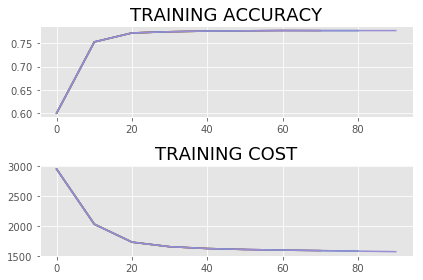

In [50]:
vocab_size = vocab.size
num_labels = 2

numEpochs = 100
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=len(train_x),
                                          decay_rate= 0.95,
                                          staircase=True)


####################
### PLACEHOLDERS ###
####################

# X = feature-matrix
X = tf.placeholder(tf.float32, [None, vocab_size], name="input")
# yGold = label-matrix. This will be our correct answers
# matrix. Every row has either [1,0] for HELPFUL or [0,1] for NOT HELPFUL.
yGold = tf.placeholder(tf.float32, [None, num_labels], name="y")

#################
### VARIABLES ###
#################

# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([vocab_size,num_labels],
                                       mean=0,
                                       stddev=(np.sqrt(6/vocab_size+
                                                         num_labels+1)),
                                       name="weights"), name="w")

bias = tf.Variable(tf.random_normal([1,num_labels],
                                    mean=0,
                                    stddev=(np.sqrt(6/vocab_size+num_labels+1)),
                                    name="bias"), name="b")

# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. LOGISTIC REGRESSION ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

#####################
### EVALUATION OP ###
#####################

# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

#######################
### OPTIMIZATION OP ###
#######################

# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

###########################
### GRAPH LIVE UPDATING ###
###########################

epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

#####################
### RUN THE GRAPH ###
#####################

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
predictions_OP = tf.argmax(activation_OP, 1)
actual_OP = tf.argmax(yGold, 1)
correct_predictions_OP = tf.equal(predictions_OP, actual_OP)
# correct_predictions_OP = tf.equal(activation_OP,yGold)
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Precision
precision_OP = tf.metrics.precision(predictions_OP, actual_OP)
# Recall
recall_OP = tf.metrics.recall(predictions_OP, actual_OP)
# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP,
                                   weightSummary, biasSummary])
# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: train_x, yGold: train_y_norm})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP], 
                feed_dict={X: train_x, yGold: train_y_norm}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)


# How well do we perform on held-out test data?
accuracy, predictions = sess.run([accuracy_OP, predictions_OP], 
                                 feed_dict={X: test_x, 
                                            yGold: test_y_norm})
print("final accuracy on test set: %s" %str(accuracy))

In [38]:
precision = metrics.precision_score(test_y_norm[:,0], 1-predictions)
recall = metrics.recall_score(test_y_norm[:,0], 1-predictions)
f1 = metrics.f1_score(test_y_norm[:,0], 1-predictions)
print("precision: %s, recall: %s, f1: %s" %(str(precision), str(recall), str(f1)))

print "confusion_matrix"
print metrics.confusion_matrix(test_y_norm[:,0], 1-predictions)
fpr, tpr, thresholds = metrics.roc_curve(test_y_norm[:,0], 1-predictions)
print fpr
print tpr
print thresholds

precision: 0.788010716678, recall: 0.996189669771, f1: 0.879955123411
confusion_matrix
[[   5  633]
 [   9 2353]]
[ 0.          0.99216301  1.        ]
[ 0.          0.99618967  1.        ]
[2 1 0]


In [259]:
print 1-predictions[0:10]
print test_y_norm[:,0]
print len(predictions) - sum(predictions)
print np.sum(test_y_norm[:,0])

[1 1 1 1 1 1 1 1 1 1]
[ 0.  1.  1. ...,  0.  1.  1.]
2993
2373.0


#### Neural Network with TF

In [13]:
# Converts sentences to tokens.
reload(utils)

max_length = 100
rnn_train_x = utils.pad_sents(utils.tokenize_sents(train_sents, vocab), max_length)
rnn_test_x = utils.pad_sents(utils.tokenize_sents(test_sents, vocab), max_length)

In [17]:
print rnn_train_x.shape
print rnn_test_x.shape

(7000, 100)
(3000, 100)


In [21]:
# Use normalized helpfulness as output.
rnn_train_y = y_norm[:7000]
rnn_test_y = y_norm[7000:10000]
print len(rnn_train_y)
print len(rnn_test_y)

7000
3000


In [56]:
tf.reset_default_graph()
tf.set_random_seed(42)

##
# Hyperparameters
# Vocab size
V = 10000
# Embedding size
M = 30
# Context window size
N = 100
# Hidden units
H = 50

# Inputs
# Using "None" in place of batch size allows 
# it to be dynamically computed later.
with tf.name_scope("Inputs"):
    ids_ = tf.placeholder(tf.int64, shape=[None, N], name="ids")
    y_ = tf.placeholder(tf.int64, shape=[None], name="y")
    
with tf.name_scope("Embedding_Layer"):
    C_ = tf.Variable(tf.random_uniform([V, M], -1.0, 1.0), name="C")
    # embedding_lookup gives shape (batch_size, N, M)
    x_ = tf.reshape(tf.nn.embedding_lookup(C_, ids_), 
                    [-1, N*M], name="x")
    
with tf.name_scope("Hidden_Layer"):
    W1_ = tf.Variable(tf.random_normal([N*M,H]), name="W1")
    b1_ = tf.Variable(tf.zeros([H,], dtype=tf.float32), name="b1")
    h_ = tf.tanh(tf.matmul(x_, W1_) + b1_, name="h")
    
with tf.name_scope("Output_Layer"):
    W2_ = tf.Variable(tf.random_normal([H,2]), name="W2")
    W3_ = tf.Variable(tf.random_normal([N*M,2]), name="W3")
    b3_ = tf.Variable(tf.zeros([2,], dtype=tf.float32), name="b3")
    # Concat [h x] and [W2 W3]
    hx_ = tf.concat([h_, x_], 1, name="hx")
    W23_ = tf.concat([W2_, W3_], 0, name="W23")
    logits_ = tf.add(tf.matmul(hx_, W23_), b3_, name="logits")

In [57]:
with tf.name_scope("Cost_Function"):
    # Sampled softmax loss, for training
    per_example_train_loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=logits_,
                                             name="per_example_train_loss_")
    train_loss_ = tf.reduce_mean(per_example_train_loss_, name="loss")

In [58]:
with tf.name_scope("Training"):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdagradOptimizer(alpha_)
    train_step_ = optimizer_.minimize(train_loss_)
    
# Initializer step
init_ = tf.global_variables_initializer()

In [59]:
with tf.name_scope("Prediction"):
    pred_proba_ = tf.nn.softmax(logits_, name="pred_proba")
    pred_max_ = tf.argmax(logits_, 1, name="pred_max")

In [60]:
with tf.name_scope("Scoring"):
    correct_predictions_OP = tf.equal(pred_max_, y_)
    accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

In [81]:
##
# Helper functions for training
def train_batch(session, batch, alpha):
    # Feed last column as targets
    feed_dict = {ids_:batch[0],
                 y_:batch[1],
                 alpha_:alpha}
    c, _ = session.run([train_loss_, train_step_],
                       feed_dict=feed_dict)
    return c

def batch_generator(data, labels, batch_size):
    """Generate minibatches from data."""
    for i in xrange(0, len(data), batch_size):
        yield (data[i:i+batch_size], labels[i:i+batch_size].reshape(-1))

In [82]:
# One epoch = one pass through the training data
num_epochs = 3
batch_size = 100
alpha = 0.5  # learning rate
print_every = 1000

np.random.seed(42)

session = tf.Session()
session.run(init_)

t0 = time.time()
for epoch in xrange(1,num_epochs+1):
    t0_epoch = time.time()
    epoch_cost = 0.0
    total_batches = 0
    print ""
    for i, batch in enumerate(batch_generator(rnn_train_x, rnn_train_y, batch_size)):
        if (i % print_every == 0):
            print "[epoch %d] seen %d minibatches" % (epoch, i)
        
        epoch_cost += train_batch(session, batch, alpha)
        total_batches = i + 1

    avg_cost = epoch_cost / total_batches
    print "[epoch %d] Completed %d minibatches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch))
    print "[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)


[epoch 1] seen 0 minibatches
[epoch 1] Completed 69 minibatches in 0:00:01
[epoch 1] Average cost: 11.600

[epoch 2] seen 0 minibatches
[epoch 2] Completed 69 minibatches in 0:00:01
[epoch 2] Average cost: 2.479

[epoch 3] seen 0 minibatches
[epoch 3] Completed 69 minibatches in 0:00:01
[epoch 3] Average cost: 0.650


In [83]:
def score_batch(session, batch):
    # Feed last column as targets
    feed_dict = {ids_:batch[0],
                 y_:batch[1]}
    predictions, accuracy = session.run([pred_max_, accuracy_OP],
                       feed_dict=feed_dict)
    print predictions[:10]
    print "total 1s predicted: %g" %sum(predictions)
    print "total 1s actual: %g" %sum(rnn_train_y)
    print "total predictions: %g" %len(predictions)
    print "accuracy: %f" %accuracy

In [84]:
score_batch(session, (rnn_train_x, rnn_train_y.reshape(-1)))

[1 1 0 1 0 0 1 1 1 1]
total 1s predicted: 5305
total 1s actual: 5444
total predictions: 7000
accuracy: 0.956714


## Scratch Below

In [ ]:
print 1

In [62]:
import nltk
nltk.download('brown')

corpus = nltk.corpus.brown

[nltk_data] Downloading package brown to /Users/legu/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [72]:
!pip install vocabulary

    100% |████████████████████████████████| 593kB 408kB/s 
    100% |████████████████████████████████| 61kB 1.9MB/s 
    100% |████████████████████████████████| 102kB 1.2MB/s 
  Running setup.py bdist_wheel for vocabulary ... - \ done
  Stored in directory: /Users/legu/Library/Caches/pip/wheels/36/6c/c0/92bb20f79402d055c3bce3e89d9f2cce5d6937bc2aadc0fb45
Successfully built vocabulary
  Found existing installation: requests 2.11.1
    Uninstalling requests-2.11.1:
      Successfully uninstalled requests-2.11.1
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
import utils
import vocabulary
# train_sents, test_sents = utils.get_train_test_sents(corpus, split=0.8, shuffle=True)
vocab = vocabulary.Vocabulary(utils.canonicalize_word(w) for w in utils.flatten(corpus))
print "Train set vocabulary: %d words" % vocab.size

AttributeError: 'module' object has no attribute 'Vocabulary'